In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gensim
import gzip
import torch
import numpy as np
import pandas as pd

In [3]:
#knock70.py
cat = str.maketrans({'b':'0', 't':'1', 'e':'2', 'm':'3'})
model = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Git\GoogleNews-vectors-negative300.bin.gz', binary=True)


def vector_xy(data_name):
    x_vec = []
    y_vec = []
    with open(data_name, encoding="utf-8") as f:
        for line in f:
            y, x = line.strip().split("\t")
            sent_vec = []
            for word in x.split(" "):
                if word not in model:
                    continue
                sent_vec.append(model[word])
            if(len(sent_vec) == 0):
                x_vec.append(np.zeros(300))
            else:
                x_vec.append(sum(sent_vec)/len(sent_vec))
            y_vec.append(int(y.translate(cat)))
    x_vec = torch.tensor(x_vec).float()
    y_vec = torch.tensor(y_vec)
    return x_vec, y_vec

x_train, y_train = vector_xy(r'C:\Git\train.txt')
x_valid, y_valid = vector_xy(r'C:\Git\valid.txt')
x_test, y_test = vector_xy(r'C:\Git\test.txt')
torch.save(x_train, r'C:\Git\x_train.pt')
torch.save(y_train, r'C:\Git\y_train.pt')
torch.save(x_valid, r'C:\Git\x_valid.pt')
torch.save(y_valid, r'C:\Git\y_valid.pt')
torch.save(x_test, r'C:\Git\x_test.pt')
torch.save(y_test, r'C:\Git\y_test.pt')

In [4]:
#knock71.py
x_train = torch.load(r'C:\Git\x_train.pt')
W = 0.2*torch.randn(300, 4)-0.1
softmax = torch.nn.Softmax(dim=1)
print(softmax(torch.matmul(x_train[:1], W)))
print(softmax(torch.matmul(x_train[:4], W)))

tensor([[0.2512, 0.2666, 0.2481, 0.2340]])
tensor([[0.2512, 0.2666, 0.2481, 0.2340],
        [0.1723, 0.1972, 0.2987, 0.3317],
        [0.1572, 0.2088, 0.2973, 0.3366],
        [0.1932, 0.1835, 0.3322, 0.2911]])


In [33]:
#knock72.py
y_train = torch.load(r'C:\Git\y_train.pt')
c_loss = torch.nn.CrossEntropyLoss()
print(c_loss(torch.matmul(x_train[:1], W), y_train[:1]))
print(c_loss(torch.matmul(x_train[:4], W), y_train[:4]))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)

In [6]:
#knock73.py
#https://kento1109.hatenablog.com/entry/2018/02/19/113849
#https://pytorch.org/docs/stable/optim.html
from torch.utils.data import DataLoader
from tqdm import tqdm

class LogisticNet(torch.nn.Module):
    def __init__(self, D_in=300, D_out=4):
        super().__init__()
        self.linear = torch.nn.Linear(D_in, D_out)
        torch.nn.init.normal_(self.linear.weight, -0.1, 0.1)
    def forward(self, x):
        return self.linear(x)

def create_data(x, y):
    data = []
    for i in range(len(y)):
        data.append([x[i], y[i]])
    return data
    
model = LogisticNet()
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

for epoch in tqdm(range(20)):
    for inputs, target in train_loader:
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()

100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


In [49]:
#knock74.py
def calc_accuracy(pred, answer):
    correct = 0
    for i in range(len(answer)):
        if pred[i] == answer[i]: correct+=1
    return correct/len(answer)

x_valid = torch.load(r'C:\Git\x_valid.pt')
y_valid = torch.load(r'C:\Git\y_valid.pt')
pred = model(x_train)
print(calc_accuracy(torch.argmax(pred, dim=1), y_train))
pred = model(x_valid)
print(calc_accuracy(torch.argmax(pred, dim=1), y_valid))

0.42334331710969675


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat1 in method wrapper_addmm)

100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


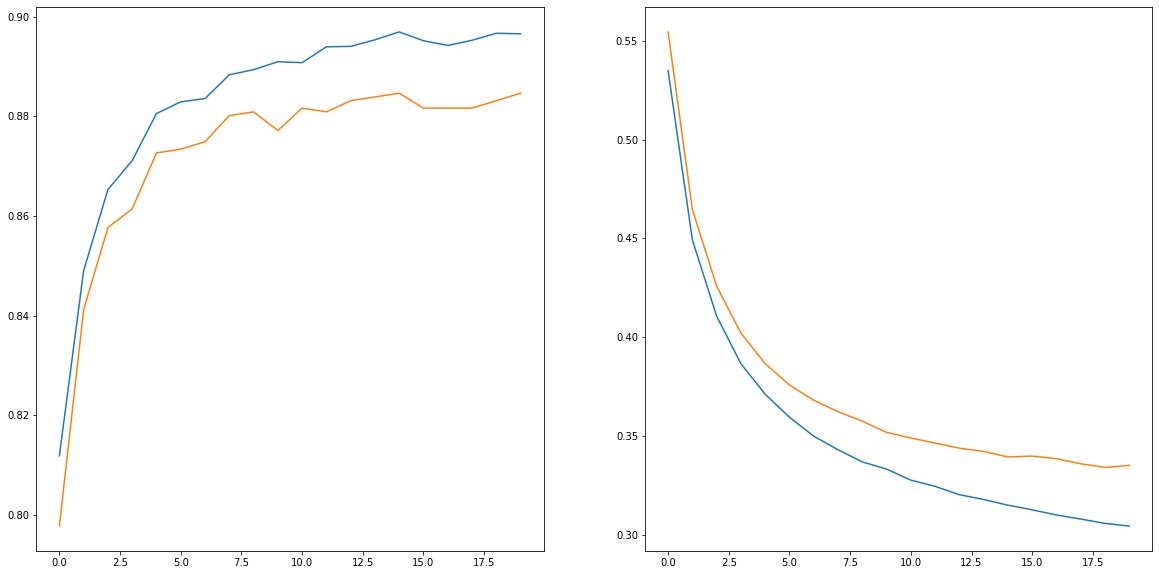

In [8]:
#knock75.py
from matplotlib import pyplot as plt

model = LogisticNet()
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

train_accuracy = []
valid_accuracy = []
train_loss = []
valid_loss = []
for epoch in tqdm(range(20)):
    for inputs, target in train_loader:
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train))
        pred = model(x_valid)
        valid_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_valid))
        valid_loss.append(loss_func(pred, y_valid))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.show()

100%|██████████| 20/20 [01:56<00:00,  5.85s/it]


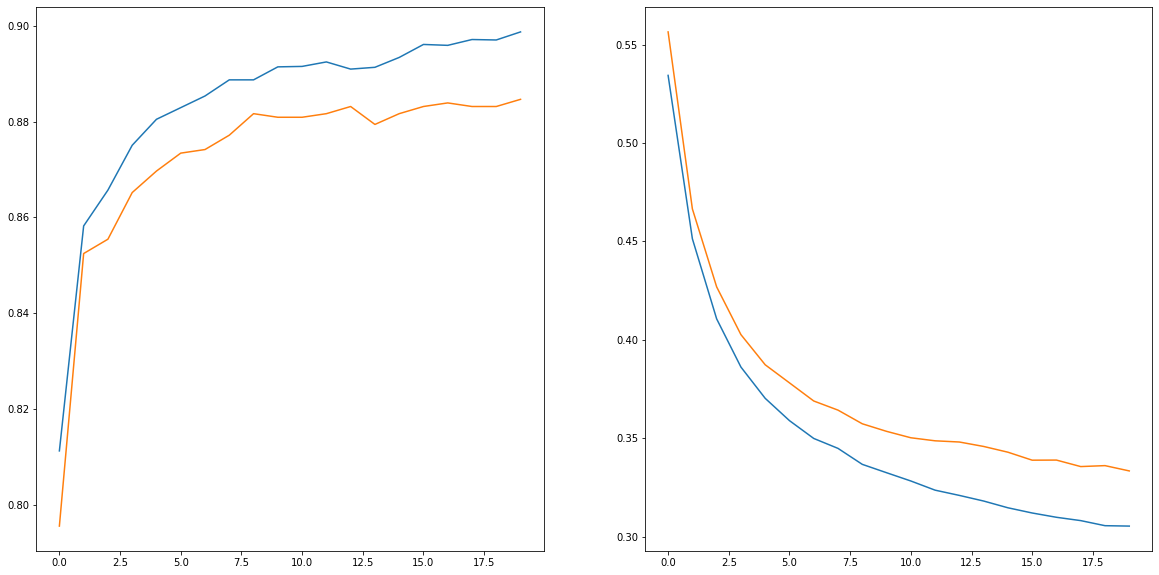

In [9]:
#knock76.py
model = LogisticNet()
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_accuracy = []
valid_accuracy = []
train_loss = []
valid_loss = []
for epoch in tqdm(range(20)):
    for inputs, target in train_loader:
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
        torch.save({'epoch':epoch, 'model':model.state_dict(), 'optim':optim.state_dict()}, f'C:\Git\checkpoints\checkpoint_{epoch+1}.pt')
    with torch.no_grad():
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train))
        pred = model(x_valid)
        valid_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_valid))
        valid_loss.append(loss_func(pred, y_valid))
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.show()

In [10]:
#knock77.py
batch_size = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
for b in batch_size:
    model = LogisticNet()
    dataset = create_data(x_train, y_train)
    train_loader = DataLoader(dataset, batch_size = b, shuffle = True)
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.CrossEntropyLoss()
    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    for epoch in tqdm(range(5)):
        for inputs, target in train_loader:
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, target)
            loss.backward()
            optim.step()
            torch.save({'epoch':epoch, 'model':model.state_dict(), 'optim':optim.state_dict()}, f'C:\Git\checkpoints\checkpoint_{epoch+1}.pt')
        with torch.no_grad():
            pred = model(x_train)
            train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
            train_loss.append(loss_func(pred, y_train))
            pred = model(x_valid)
            valid_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_valid))
            valid_loss.append(loss_func(pred, y_valid))
#batch_size=1 00:27
#batch_size=2 00:15
#batch_size=4 00:08
#batch_size=8 00:04
#batch_size=16 00:02
#batch_size=32 00:01
#batch_size=64 00:00
#batch_size=128 00:00
#batch_size=256 00:00
#batch_size=512 00:00
#batch_size=1024 00:00

100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


In [19]:
#knock78.py
batch_size = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
for b in batch_size:
    device = torch.device('cuda')
    model = LogisticNet()
    dataset = create_data(x_train, y_train)
    train_loader = DataLoader(dataset, batch_size = b, shuffle = True)
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.CrossEntropyLoss()
    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    for epoch in tqdm(range(5)):
        for inputs, target in train_loader:
            optim.zero_grad()
            model.to(device)
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, target)
            loss.backward()
            optim.step()
            torch.save({'epoch':epoch, 'model':model.state_dict(), 'optim':optim.state_dict()}, f'C:\Git\checkpoints\checkpoint_{epoch+1}.pt')
        with torch.no_grad():
            x_train = x_train.to(device)
            x_valid = x_valid.to(device)
            pred = model(x_train)
            train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
            train_loss.append(loss_func(pred, y_train))
            pred = model(x_valid)
            valid_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_valid))
            valid_loss.append(loss_func(pred, y_valid))
#batch_size=1 00:56
#batch_size=2 00:28
#batch_size=4 00:14
#batch_size=8 00:07
#batch_size=16 00:03
#batch_size=32 00:01
#batch_size=64 00:01
#batch_size=128 00:00
#batch_size=256 00:00
#batch_size=512 00:00
#batch_size=1024 00:00

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[0.9175, 0.0000, 0.0000, 0.0000],
        [0.9175, 0.0000, 0.0000, 0.0000],
        [0.9175, 0.0000, 0.0000, 0.0000],
        ...,
        [0.9175, 0.0000, 0.0000, 0.0000],
        [0.9175, 0.0000, 0.0000, 0.0000],
        [0.9175, 0.0000, 0.0000, 0.0000]], device='cuda:0')


  2%|▏         | 1/50 [00:09<08:05,  9.90s/it]

tensor([[0.8867, 0.0000, 0.0000, 0.0000],
        [0.8867, 0.0000, 0.0000, 0.0000],
        [0.8867, 0.0000, 0.0000, 0.0000],
        ...,
        [0.8867, 0.0000, 0.0000, 0.0000],
        [0.8867, 0.0000, 0.0000, 0.0000],
        [0.8867, 0.0000, 0.0000, 0.0000]], device='cuda:0')


  4%|▍         | 2/50 [00:19<07:57,  9.95s/it]

tensor([[0.8984, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [1.6384, 0.0000, 0.0000, 0.0000],
        ...,
        [0.9887, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


  6%|▌         | 3/50 [00:29<07:46,  9.93s/it]

tensor([[2.8950, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [2.8950, 0.0000, 0.0000, 0.0000],
        ...,
        [0.5888, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


  8%|▊         | 4/50 [00:39<07:37,  9.95s/it]

tensor([[3.4208, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.6342, 0.0000],
        [3.4208, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.3264, 0.0000],
        [0.0000, 0.0000, 3.3142, 0.0000]], device='cuda:0')


 10%|█         | 5/50 [00:50<07:33, 10.08s/it]

tensor([[3.6718, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 7.5925, 0.0000],
        [3.6718, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 6.7912, 0.0000],
        [0.0000, 0.0000, 2.3805, 0.0000]], device='cuda:0')


 12%|█▏        | 6/50 [01:00<07:24, 10.11s/it]

tensor([[3.8753, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.1680, 0.0000],
        [3.8753, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 5.6411, 0.0000],
        [0.0000, 0.0000, 2.1092, 0.0000]], device='cuda:0')


 14%|█▍        | 7/50 [01:10<07:15, 10.13s/it]

tensor([[4.0200, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.6852, 0.0000],
        [4.0200, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 7.4145, 0.0000],
        [0.0000, 0.0000, 1.9415, 0.0000]], device='cuda:0')


 16%|█▌        | 8/50 [01:20<07:05, 10.14s/it]

tensor([[4.0354, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.1126, 0.0000],
        [4.0354, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 6.8662, 0.0000],
        [0.0000, 0.0000, 1.1881, 0.0000]], device='cuda:0')


 18%|█▊        | 9/50 [01:30<06:55, 10.14s/it]

tensor([[4.1461, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.3458, 0.0000],
        [4.1461, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.7769, 0.0000],
        [0.0000, 0.0000, 3.5271, 0.0000]], device='cuda:0')


 20%|██        | 10/50 [01:40<06:45, 10.14s/it]

tensor([[ 4.1620,  0.1684,  0.0000,  0.0000],
        [ 0.0000,  0.7049,  3.3032,  0.0000],
        [ 4.1620,  0.1684,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.5514,  0.0000,  0.0000],
        [ 0.0000,  0.7169, 10.2907,  0.0000],
        [ 0.0000,  0.5810,  1.7449,  0.0000]], device='cuda:0')


 22%|██▏       | 11/50 [01:50<06:35, 10.14s/it]

tensor([[4.4296, 0.8002, 0.0000, 0.0000],
        [0.0000, 0.4205, 6.8161, 0.0000],
        [4.4296, 0.8002, 0.0000, 0.0000],
        ...,
        [0.6253, 1.0926, 0.0000, 0.0000],
        [0.0000, 0.3450, 8.6401, 0.0000],
        [0.0000, 0.6627, 2.9362, 0.0000]], device='cuda:0')


 24%|██▍       | 12/50 [02:01<06:24, 10.11s/it]

tensor([[4.5575, 0.9332, 0.0000, 0.0000],
        [0.0000, 0.0000, 5.4259, 0.0000],
        [4.5575, 0.9332, 0.0000, 0.0000],
        ...,
        [0.0000, 1.1111, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.6376, 0.0000],
        [0.0000, 0.7922, 1.4250, 0.0000]], device='cuda:0')


 26%|██▌       | 13/50 [02:11<06:12, 10.08s/it]

tensor([[4.5306e+00, 9.4277e-01, 3.7066e-02, 0.0000e+00],
        [0.0000e+00, 1.2720e-01, 5.7992e+00, 0.0000e+00],
        [4.5306e+00, 9.4277e-01, 3.7066e-02, 0.0000e+00],
        ...,
        [7.0466e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 6.4790e-05, 6.5753e+00, 0.0000e+00],
        [0.0000e+00, 6.5305e-01, 2.9305e+00, 0.0000e+00]], device='cuda:0')


 28%|██▊       | 14/50 [02:21<06:01, 10.05s/it]

tensor([[ 4.5999,  0.9525,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9367,  0.0000],
        [ 4.5999,  0.9525,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.1430, 11.2534,  0.0000],
        [ 0.0000,  0.9131,  2.2402,  0.0000]], device='cuda:0')


 30%|███       | 15/50 [02:31<05:51, 10.04s/it]

tensor([[4.5775, 0.8954, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.8829, 0.0000],
        [4.5775, 0.8954, 0.0000, 0.0000],
        ...,
        [4.5775, 0.8954, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.7633, 0.0000],
        [0.0000, 0.5213, 1.5365, 0.0000]], device='cuda:0')


 32%|███▏      | 16/50 [02:41<05:41, 10.04s/it]

tensor([[4.6281, 0.8642, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.0729, 0.0000],
        [4.6281, 0.8642, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 8.7678, 0.0000],
        [0.0000, 0.5153, 3.0568, 0.0000]], device='cuda:0')


 34%|███▍      | 17/50 [02:51<05:31, 10.03s/it]

tensor([[ 4.6927,  0.9540,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.3647,  0.0000],
        [ 4.6927,  0.9540,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 13.6434,  0.0000],
        [ 0.0000,  0.4551,  5.0169,  0.0000]], device='cuda:0')


 36%|███▌      | 18/50 [03:01<05:21, 10.05s/it]

tensor([[ 4.7930,  0.8940,  0.0000,  0.0000],
        [ 0.0000,  1.0010,  9.1913,  0.0000],
        [ 4.7930,  0.8940,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.2156,  0.0000],
        [ 0.0000,  0.6780,  3.5121,  0.0000]], device='cuda:0')


 38%|███▊      | 19/50 [03:11<05:10, 10.03s/it]

tensor([[ 4.6600,  0.9219,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.5251,  0.0000],
        [ 4.6600,  0.9219,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.9441,  0.0000],
        [ 0.0000,  0.2159,  5.2822,  0.0000]], device='cuda:0')


 40%|████      | 20/50 [03:21<05:00, 10.03s/it]

tensor([[ 4.7595,  0.9144,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  7.6095,  0.0000],
        [ 4.7595,  0.9144,  0.0000,  0.0000],
        ...,
        [ 0.7155,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.9403,  0.0000],
        [ 0.0000,  0.4019,  4.2007,  0.0000]], device='cuda:0')


 42%|████▏     | 21/50 [03:31<04:50, 10.02s/it]

tensor([[ 4.7664,  0.8782,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.1412,  0.0000],
        [ 4.8067,  0.8954,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.4070,  0.0000],
        [ 0.0000,  0.0234,  2.5513,  0.0000]], device='cuda:0')


 44%|████▍     | 22/50 [03:41<04:40, 10.02s/it]

tensor([[ 4.9601,  1.0276,  0.0000,  0.0000],
        [ 0.0000,  0.2487,  6.7833,  0.0000],
        [ 4.9633,  0.9776,  0.0000,  0.0000],
        ...,
        [ 3.2266,  0.3151,  0.1010,  0.0000],
        [ 0.0000,  0.0000, 13.5566,  0.0000],
        [ 0.0000,  0.6374,  4.1625,  0.0000]], device='cuda:0')


 46%|████▌     | 23/50 [03:51<04:31, 10.05s/it]

tensor([[ 4.8466,  1.0384,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.8494,  0.0000],
        [ 5.0919,  1.1009,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 14.8048,  0.0000],
        [ 0.0000,  0.9869,  3.7149,  0.0000]], device='cuda:0')


 48%|████▊     | 24/50 [04:01<04:22, 10.08s/it]

tensor([[ 5.2619,  1.1280,  0.0000,  0.0000],
        [ 0.0000,  0.3719,  7.6910,  0.0000],
        [ 5.2721,  1.0360,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 15.5234,  0.0000],
        [ 0.0000,  0.7767,  4.0938,  0.0000]], device='cuda:0')


 50%|█████     | 25/50 [04:11<04:11, 10.07s/it]

tensor([[ 5.3232,  1.2113,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.6816,  0.0000],
        [ 5.3232,  1.2113,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 21.7040,  0.0000],
        [ 0.0000,  0.1410,  7.8495,  0.0000]], device='cuda:0')


 52%|█████▏    | 26/50 [04:21<04:01, 10.06s/it]

tensor([[ 3.9702,  0.9630,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.3207,  0.0000],
        [ 5.2832,  1.3211,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 16.0746,  0.0000],
        [ 0.0000,  0.1224,  3.1667,  0.0000]], device='cuda:0')


 54%|█████▍    | 27/50 [04:31<03:51, 10.05s/it]

tensor([[ 5.3505,  1.2362,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 13.9150,  0.0000],
        [ 5.3861,  1.0683,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 19.1562,  0.0000],
        [ 0.0000,  0.7716,  1.8698,  0.0000]], device='cuda:0')


 56%|█████▌    | 28/50 [04:41<03:41, 10.05s/it]

tensor([[ 5.3694,  1.3484,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 11.2480,  0.0000],
        [ 5.3694,  1.3484,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 17.5158,  0.0000],
        [ 0.0000,  0.9039,  4.8172,  0.0000]], device='cuda:0')


 58%|█████▊    | 29/50 [04:51<03:31, 10.05s/it]

tensor([[ 5.2024,  1.2788,  0.3640,  0.0000],
        [ 0.0000,  0.0000, 12.0400,  0.0000],
        [ 5.4657,  1.1197,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 15.2035,  0.0000],
        [ 0.0000,  0.0000,  6.1340,  0.0000]], device='cuda:0')


 60%|██████    | 30/50 [05:01<03:20, 10.04s/it]

tensor([[ 5.4583,  1.3695,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 13.0227,  0.0000],
        [ 5.5952,  1.0096,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 19.3619,  0.0000],
        [ 0.0263,  0.2150,  4.7764,  0.0000]], device='cuda:0')


 62%|██████▏   | 31/50 [05:11<03:10, 10.05s/it]

tensor([[ 5.5186,  1.2556,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0941,  0.0000],
        [ 5.7442,  0.7130,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 20.1350,  0.0000],
        [ 0.0000,  0.4395,  4.7616,  0.0000]], device='cuda:0')


 64%|██████▍   | 32/50 [05:21<03:00, 10.04s/it]

tensor([[ 5.5075,  1.2415,  0.0000,  0.0000],
        [ 0.0000,  0.4122,  9.2664,  0.0000],
        [ 5.8268,  0.6043,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 19.2647,  0.0000],
        [ 0.0000,  1.2856,  2.9984,  0.0000]], device='cuda:0')


 66%|██████▌   | 33/50 [05:31<02:50, 10.04s/it]

tensor([[ 5.4362,  1.4571,  0.0000,  0.0000],
        [ 0.0000,  0.8707,  9.0831,  0.0000],
        [ 5.8648,  0.6772,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 18.6992,  0.0000],
        [ 1.2248,  1.2092,  2.2994,  0.0000]], device='cuda:0')


 68%|██████▊   | 34/50 [05:41<02:41, 10.07s/it]

tensor([[ 5.4159,  1.4452,  0.0000,  0.0000],
        [ 0.0000,  0.1455, 13.4206,  0.0000],
        [ 5.7406,  0.8679,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 16.8898,  0.0000],
        [ 0.0000,  0.0000,  4.4064,  0.0000]], device='cuda:0')


 70%|███████   | 35/50 [05:52<02:30, 10.06s/it]

tensor([[ 5.3950,  1.3924,  0.0000,  0.0000],
        [ 0.0000,  0.2917,  6.6632,  0.0000],
        [ 5.3033,  1.5592,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 24.2404,  0.0000],
        [ 0.0000,  0.0000,  5.9196,  0.0000]], device='cuda:0')


 72%|███████▏  | 36/50 [06:02<02:20, 10.06s/it]

tensor([[ 5.6297,  1.0532,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 15.6523,  0.0000],
        [ 6.1163,  0.1438,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 22.0529,  0.0000],
        [ 0.0000,  0.0000,  5.5680,  0.0000]], device='cuda:0')


 74%|███████▍  | 37/50 [06:12<02:10, 10.07s/it]

tensor([[ 5.5653,  1.2768,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 14.7280,  0.0000],
        [ 6.1105,  0.2805,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 20.2208,  0.0000],
        [ 0.0000,  0.0000,  5.6731,  0.0000]], device='cuda:0')


 76%|███████▌  | 38/50 [06:22<02:00, 10.05s/it]

tensor([[ 5.6331,  1.0651,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.8338,  0.0000],
        [ 5.8841,  0.5767,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 21.6637,  0.0000],
        [ 0.0000,  0.0000,  5.7880,  0.0000]], device='cuda:0')


 78%|███████▊  | 39/50 [06:32<01:50, 10.04s/it]

tensor([[ 5.5361,  1.2919,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 15.3878,  0.0000],
        [ 6.1056,  0.0251,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 15.1201,  0.0000],
        [ 0.0000,  0.0000,  6.4146,  0.0000]], device='cuda:0')


 80%|████████  | 40/50 [06:42<01:40, 10.03s/it]

tensor([[5.5179e+00, 1.3368e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.2418e+00, 1.0036e+01, 0.0000e+00],
        [6.1875e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [0.0000e+00, 6.1404e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.8588e+01, 0.0000e+00],
        [0.0000e+00, 1.0819e-01, 4.8805e+00, 0.0000e+00]], device='cuda:0')


 82%|████████▏ | 41/50 [06:52<01:30, 10.05s/it]

tensor([[ 5.0881,  1.7355,  0.7165,  0.0000],
        [ 0.0000,  0.2277, 12.5212,  0.0000],
        [ 5.9076,  0.5894,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 25.5767,  0.0000],
        [ 0.0000,  0.0000,  5.1387,  0.0000]], device='cuda:0')


 84%|████████▍ | 42/50 [07:02<01:20, 10.03s/it]

tensor([[ 5.4613,  1.6825,  0.0000,  0.0000],
        [ 0.0000,  0.2540,  9.8360,  0.0000],
        [ 5.8961,  0.3987,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 12.3532,  0.0000],
        [ 0.6886,  0.0000,  5.5938,  0.0000]], device='cuda:0')


 86%|████████▌ | 43/50 [07:12<01:10, 10.03s/it]

tensor([[ 5.4508,  1.6793,  0.0000,  0.0000],
        [ 0.0000,  0.5537, 10.4521,  0.0000],
        [ 5.9524,  0.1707,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 17.1709,  0.0000],
        [ 0.0000,  0.0000,  6.6575,  0.0000]], device='cuda:0')


 88%|████████▊ | 44/50 [07:22<01:00, 10.01s/it]

tensor([[ 5.7131,  1.1628,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 16.9362,  0.0000],
        [ 6.3012,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 28.5862,  0.0000],
        [ 0.0000,  0.0000,  7.0144,  0.0000]], device='cuda:0')


 90%|█████████ | 45/50 [07:32<00:50, 10.02s/it]

tensor([[5.6396e+00, 1.3495e+00, 3.8713e-03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5771e+01, 0.0000e+00],
        [6.0042e+00, 1.2368e-01, 0.0000e+00, 0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5370e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 8.0647e+00, 0.0000e+00]], device='cuda:0')


 92%|█████████▏| 46/50 [07:42<00:40, 10.02s/it]

tensor([[ 5.4674,  2.1273,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 17.7853,  0.0000],
        [ 6.1524,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 21.5607,  0.0000],
        [ 0.0000,  0.0000,  4.6610,  0.0000]], device='cuda:0')


 94%|█████████▍| 47/50 [07:52<00:30, 10.02s/it]

tensor([[ 5.4831,  1.2507,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 20.0514,  0.0000],
        [ 6.1585,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 27.2577,  0.0000],
        [ 0.0000,  0.0000,  8.1905,  0.0000]], device='cuda:0')


 96%|█████████▌| 48/50 [08:02<00:20, 10.03s/it]

tensor([[ 5.6304,  1.8583,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 13.4585,  0.0000],
        [ 5.5469,  2.1597,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 15.1397,  0.0000],
        [ 0.0000,  0.0000,  5.9396,  0.0000]], device='cuda:0')


 98%|█████████▊| 49/50 [08:12<00:10, 10.04s/it]

tensor([[ 5.6978,  1.7021,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 14.2865,  0.0000],
        [ 6.1634,  0.0960,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 18.0418,  0.0000],
        [ 0.8671,  0.7822,  2.5606,  0.0000]], device='cuda:0')


100%|██████████| 50/50 [08:22<00:00, 10.05s/it]


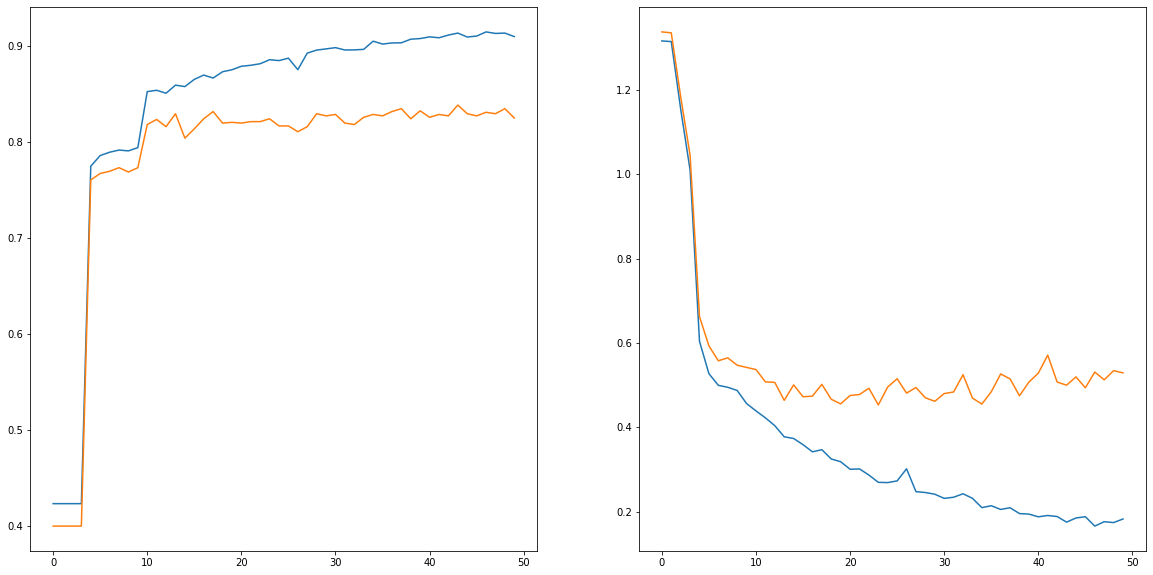

In [64]:
#knock79.py
#http://cedro3.com/ai/pytorch-mlp/
import torch.nn.functional as F
class LogisticNet(torch.nn.Module):
    def __init__(self, D_in=300, D_mid=256, D_out=4):
        super().__init__()
        self.fc1 = torch.nn.Linear(D_in, D_mid)
        self.fc2 = torch.nn.Linear(D_mid, D_mid)
        self.fc3 = torch.nn.Linear(D_mid, D_out)
        self.dropout1 = torch.nn.Dropout2d(0.1)
        self.dropout2 = torch.nn.Dropout2d(0.1)
        torch.nn.init.normal_(self.fc1.weight, -0.1, 0.1)
        torch.nn.init.normal_(self.fc2.weight, -0.1, 0.1)
        torch.nn.init.normal_(self.fc3.weight, -0.1, 0.1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return  F.relu(self.fc3(x))

device = torch.device('cuda')
model = LogisticNet()
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_accuracy = []
valid_accuracy = []
train_loss = []
valid_loss = []
for epoch in tqdm(range(50)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
        #torch.save({'epoch':epoch, 'model':model.state_dict(), 'optim':optim.state_dict()}, f'C:\Git\checkpoints\checkpoint_{epoch+1}.pt')
    with torch.no_grad():
        x_train = x_train.to(device)
        x_valid = x_valid.to(device)
        y_train = y_train.to(device)
        y_valid = y_valid.to(device)
        pred = model(x_train)
        print(pred)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train).detach().cpu().numpy())
        pred = model(x_valid)
        valid_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_valid))
        valid_loss.append(loss_func(pred, y_valid).detach().cpu().numpy())
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.show()